# Проект "Выгрузка данных для анализа из базы данных сайта StackOverFlow"

**Описание проекта**

Вы будете работать со схемой **tools_shop** базы данных интернет-магазина по продаже инструментов.

**Цель проекта**: подготовить данные для аналитической задачи.

**Задача проекта**: выгрузить из базы данных наборы данных необходимых метрик для когортного анализа за 2020 год.

**План работы**

1. Настроить соединение с базой данных.
2. Выгрузить необходимые данные.
  1. Удержание (retention) покупателей за 2020 год; возврат в январе-марте 2020 г. пользователей платформы Android, зарегистрировавшихся в январе 2020 г.
  2. Отток (churn rate) пользователей.
  3. LTV пользователей, зарегистрировавшихся в 2019 г.
3. Сделать вывод.  


**Описание данных**

[ER-диаграмма и описание базы данных](https://github.com/AVRotaev/Portfolio/blob/main/Data_export_PostgreSQL/DB_ER-diagram_describe.pdf)

[ER-диаграмма схемы tools_shop](https://github.com/AVRotaev/Portfolio/blob/main/Data_export_PostgreSQL/DB_ER-diagram.png)

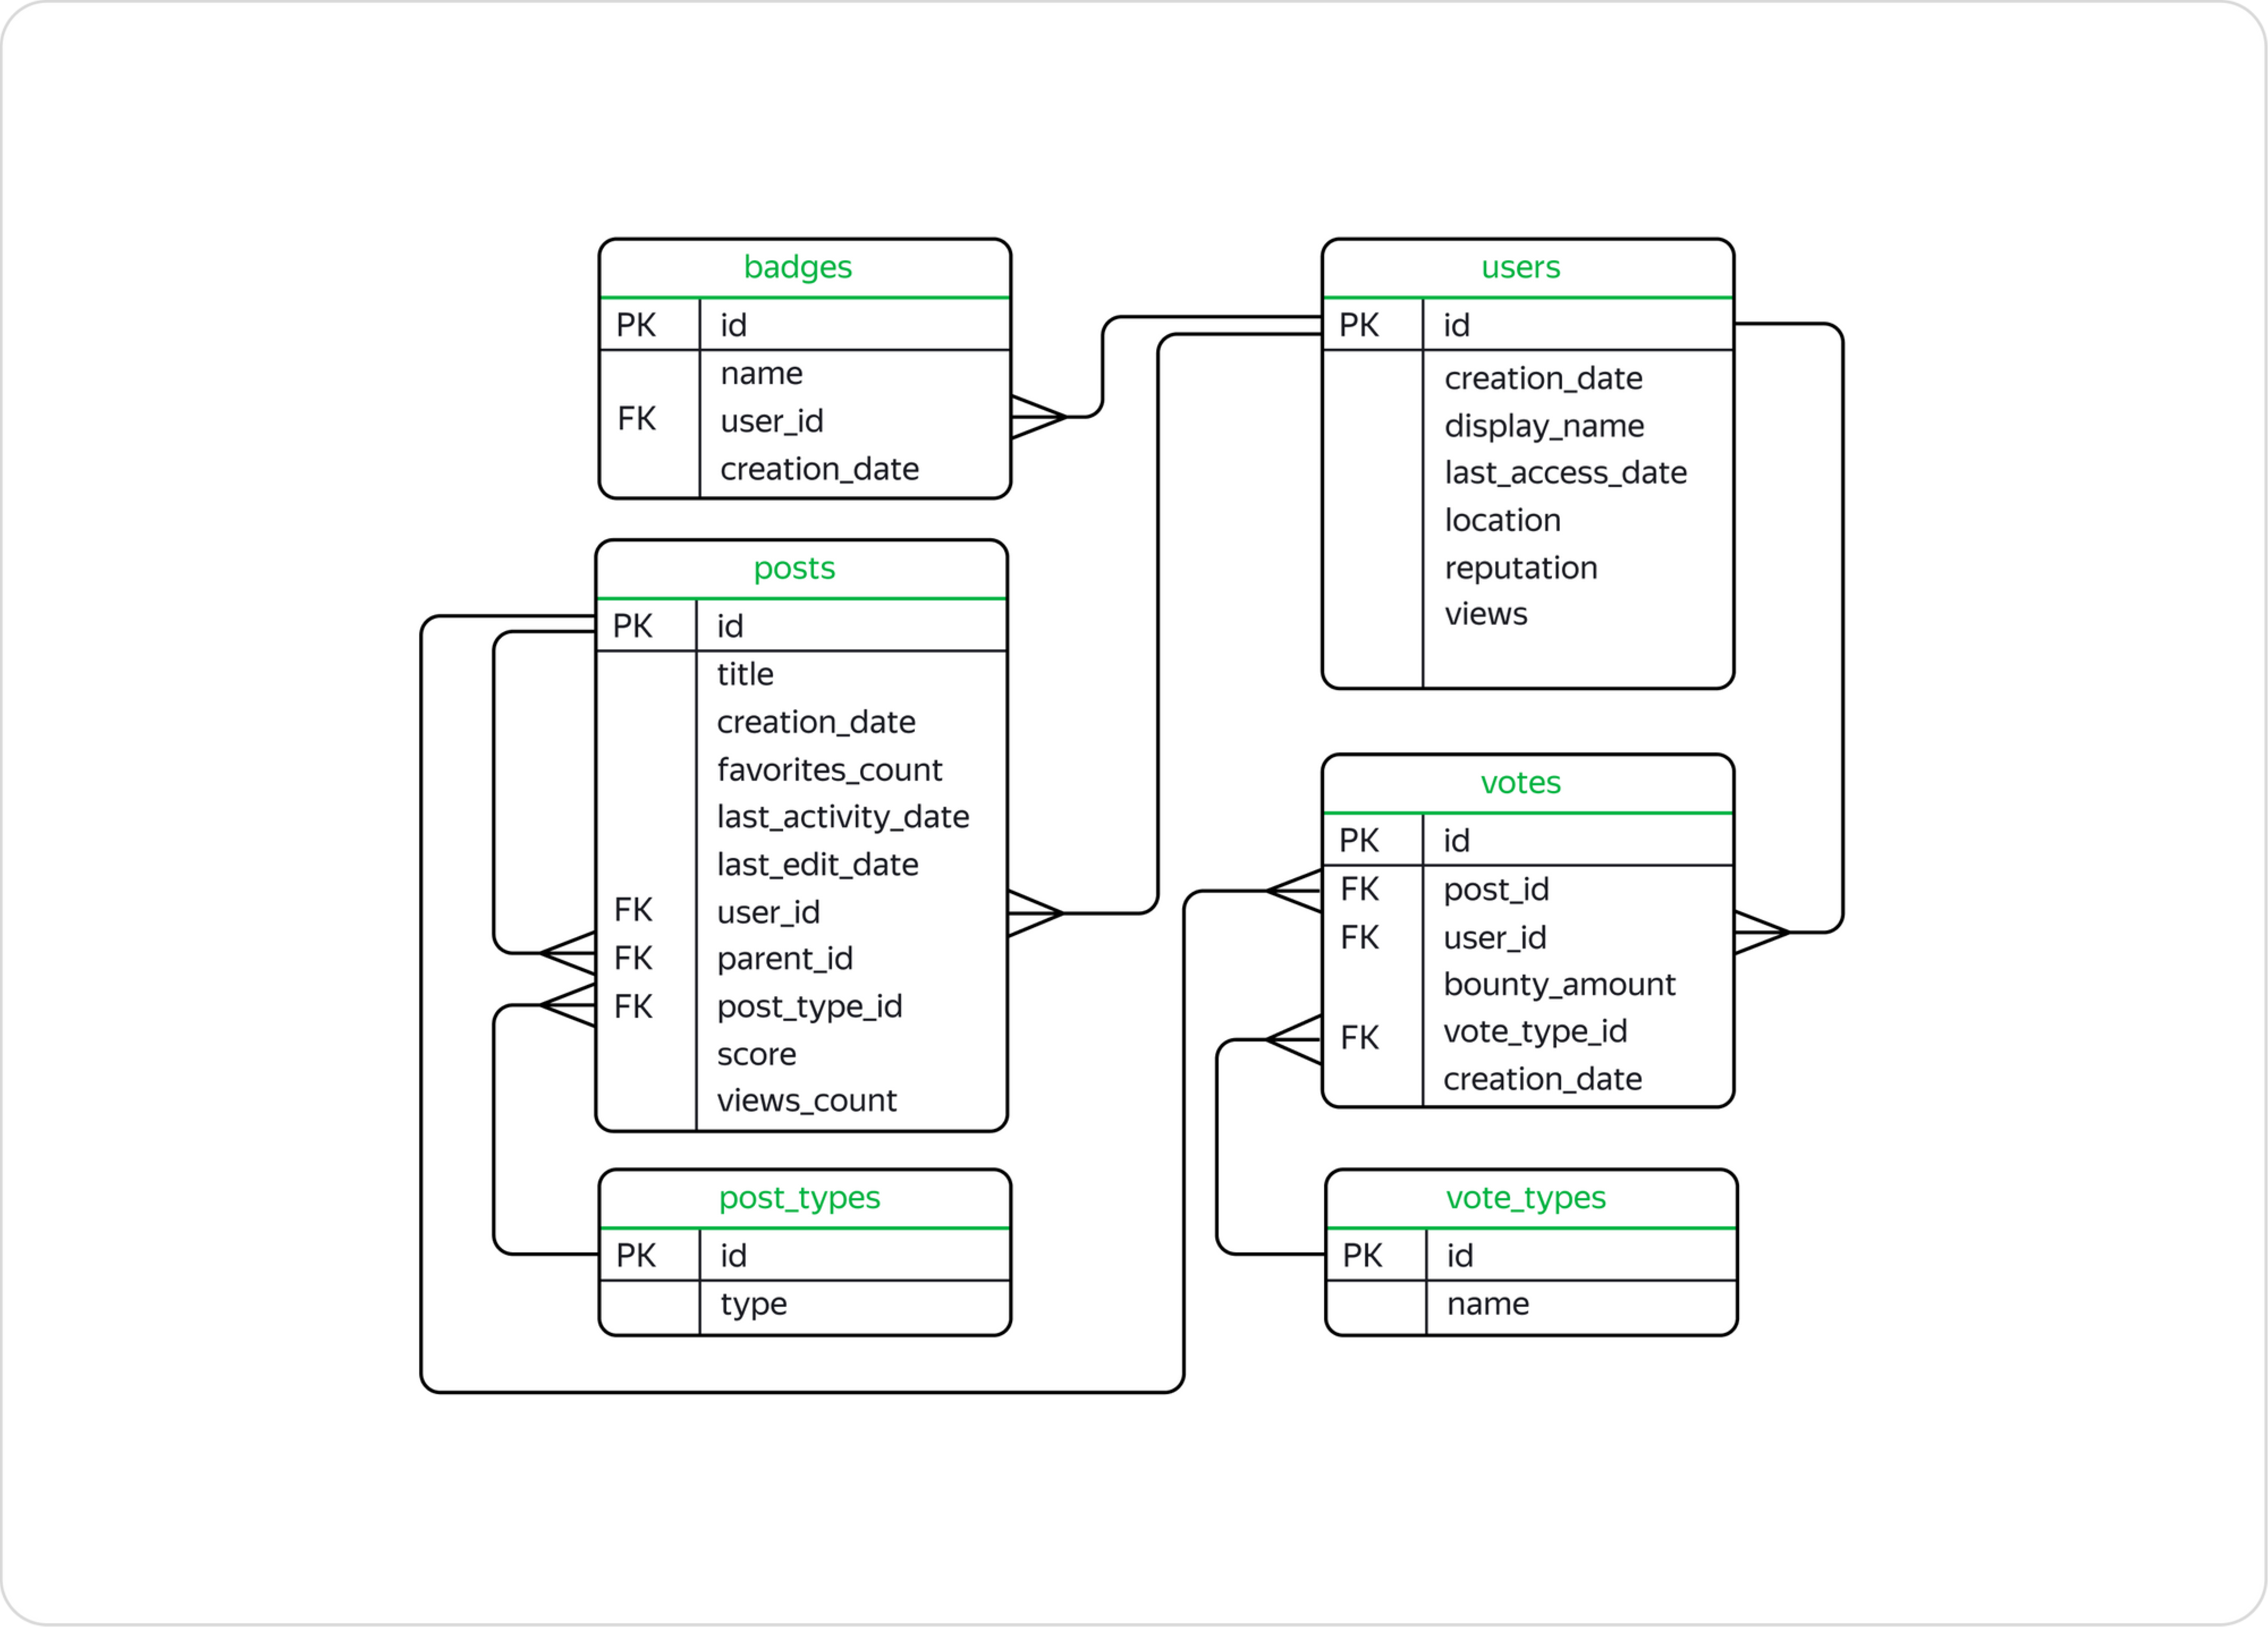


Схема **tools_shop**

Таблица **users**

Содержит данные о пользователях.

- **user_id** - Идентификатор пользователя, первичный ключ таблицы
- **first_name** - Имя пользователя
- **last_name** - Фамилия пользователя
- **email** - Электронный адрес пользователя
- **created_at** - Дата создания аккаунта пользователя

Таблица **events**

Содержит данные о событиях.

- **event_id** - Идентификатор события, первичный ключ таблицы
- **event_time** - Дата и время события
- **event_name** - Название события
- **user_id** Идентификатор пользователя, внешний ключ, отсылающий к таблице **users**
- **platform** - Тип устройства пользователя
- **referrer** - Источник события пользователя

Таблица **event_x_event_parameter**

Содержит детальную информацию о событиях.

- **event_id** - Идентификатор события, внешний ключ, отсылающий к таблице **events**
- **parameter_name** - Параметр детализации
- **parameter_value** - Значение параметра

Таблица **orders**

Содержит детальные данные о заказах пользователей.

- **order_id** - Идентификатор заказа, первичный ключ таблицы
- **user_id** - Идентификатор пользователя, оформившего заказ
- **total_amt** - Общая сумма заказа
- **items_cnt** Количество товаров в заказе
- **created_at** - Дата, когда пользователь оформил заказ, но ещё не оплатил его
- **paid_at** - Дата оплаты заказа

Таблица **items**

Содержит данные о товарах.

- **item_id** - Идентификатор товара, первичный ключ таблицы
- **category** - Категория товара
- **item_name** - Название товара
- **price** - Стоимость

Таблица **order_x_item**

- **order_id** - Идентификатор заказа, внешний ключ, отсылающий к таблице **orders**
- **item_id** - Идентификатор товара, внешний ключ, отсылающий к таблице **items**

Таблица **costs**

Содержит данные о стоимости привлечения пользователей.

- **created_at** Дата
- **costs** Стоимость привлечения


**Схема online_store**

Таблица **profiles**

Содержит данные о пользователях магазина.


- **user_id** - Идентификатор пользователя, первичный ключ таблицы
- **first_ts** - Дата и время первого посещения
- **channel** - Канал привлечения
- **device** - Тип устройства пользователя
- **region** - Регион пользователя
- **dt** - Дата первого посещения
- **month** - Месяц первого посещения
- **payer** Информация о том, совершал ли пользователь хотя бы одну покупку

Таблица **sessions**

Содержит данные о сессиях пользователей на сайте магазина.

- **user_id** - Идентификатор пользователя
- **region** - Регион посещения
- **channel** - Канал сессии
- **device** - Тип устройства сессии
- **session_duration** - Длительность сессии в секундах
- **session_start** - Дата и время старта сессии

Таблица **events**

Содержит данные о событиях.

- **user_id** - Идентификатор пользователя
- **event_dt** - Дата и время события
- **event_name** - Название события. Типов рассылки в поле **event_name** всего два:
    - onboarding — обязательная рассылка для каждого пользователя, которую отправляют самой первой и только один раз;
    - sale_offer — рассылка пользователям специальных предложений.

Таблица **orders**

Содержит детальные данные о заказах пользователей.

- **user_id** - Идентификатор пользователя
- **event_dt** - Дата и время оформления заказа
- **revenue** - Сумма заказа

Таблица **costs**

Содержит данные о стоимости привлечения новых пользователей.

- **dt** - Дата
- **channel** - Канал привлечения
- **costs** - Стоимость привлечения


## Подготовка к выгрузке данных


In [3]:
#импорт и установка необходимых библиотек
!pip install sqlalchemy

from sqlalchemy import create_engine

import pandas as pd

Настройка конфигурации подключения к базе данных.

Данные для подключения и аутентификации



In [4]:
db_config = {
    'user':'postgres',
    'pwd':'lex374239',
    'host':'localhost',
    'port':5432,
    'db':'practicum_89da'
}

In [5]:
#строка для подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

#создание соединения
engine = create_engine(connection_string)

## Выгрузка данных из базы

### Удержание покупателей (Retention rate).


#### Рассчитать и выгрузить помесячное удержание покупателей за 2020 год. 
Рассчитать и выгрузить помесячное удержание покупателей за 2020 год. В качестве названия когорты использовать номер месяца первой покупки. 

In [23]:
query = '''
WITH pr AS (SELECT user_id,
                EXTRACT(MONTH FROM paid_at) AS month, 
                MIN(EXTRACT(MONTH FROM paid_at)) OVER(PARTITION BY user_id) AS cohort
             FROM tools_shop.orders    
             WHERE EXTRACT(YEAR FROM paid_at) = '2020'
             ORDER BY user_id)
             
SELECT cohort, month,
        ROUND(users_cnt::numeric/MAX(users_cnt) OVER(PARTITION BY cohort)::numeric, 4) * 100 AS retention_rate
FROM (SELECT  cohort, month,
            COUNT(DISTINCT user_id) AS users_cnt
        FROM pr
        GROUP BY cohort, month
        ORDER BY cohort, month) AS tab
ORDER BY cohort, month        
;
'''

retention_2020 = pd.read_sql_query(query, con=engine.connect())

retention_2020.head()

,cohort,month,retention_rate
0,1.0,1.0,100.00
1,1.0,2.0,2.48
2,1.0,3.0,0.74
3,1.0,4.0,0.74
4,1.0,5.0,1.24


#### Данные о возврате пользователей платформы Android.

Рассчитать и выгрузить данные о возврате пользователей платформы Android.
Определить, сколько таких пользователей, зарегистрированных в январе 2020 года, вернулись и посетили сайт с января 2020 года по март 2020 года включительно. Не использовать максимальное значение при расчёте общего числа пользователей в когорте, чтобы избежать возникновения возможных аномалий.

In [28]:
query = '''
SELECT DATE_TRUNC('month', e.event_time)::timestamp AS event_month,
        u.users_jan,
        COUNT(DISTINCT e.user_id)/ u.users_jan::numeric AS share
FROM (SELECT *
      FROM tools_shop.events
      WHERE DATE_TRUNC('month', event_time) BETWEEN '2020-01-01' AND '2020-03-01'
            AND platform = 'android') e
JOIN (SELECT DISTINCT user_id,
                    (SELECT COUNT(DISTINCT user_id)
                    FROM tools_shop.users 
                    WHERE DATE_TRUNC('month',created_at)::date = '2020-01-01' 
                    ) AS users_jan
    FROM tools_shop.users 
    WHERE DATE_TRUNC('month',created_at)::date = '2020-01-01') u ON e.user_id = u.user_id
GROUP BY event_month, users_jan
ORDER BY event_month, users_jan
;
'''

users_jan_2020_retention = pd.read_sql_query(query, con=engine.connect())

users_jan_2020_retention

,event_month,users_jan,share
0,2020-01-01,2549,0.008631
1,2020-02-01,2549,0.025108
2,2020-03-01,2549,0.021969


### Отток пользователей (Churn_rate)

Рассчитать Churn Rate по месяцам для клиентов, проявивших любую активность.

In [29]:
query = '''
WITH pr AS (SELECT DISTINCT user_id,
                   MIN(DATE_TRUNC('month', event_time)::date) AS cohort
            FROM tools_shop.events        
            WHERE user_id IN (SELECT DISTINCT user_id
                                FROM tools_shop.orders)
            GROUP BY user_id
            ),

pr2 AS (SELECT cohort, DATE_TRUNC('month', e.event_time)::date AS event_month,
                    COUNT(DISTINCT e.user_id) AS users_cnt
            FROM pr JOIN tools_shop.events e ON pr.user_id = e.user_id
            GROUP BY cohort, event_month
            ORDER BY cohort, event_month DESC)
            
SELECT *,
        LAG(users_cnt) OVER(PARTITION BY cohort ORDER BY event_month) AS prev_month_users_cnt,
        ROUND((1 - users_cnt::numeric / LAG(users_cnt) OVER(PARTITION BY cohort ORDER BY event_month)) *100 , 2) AS CR_percent
FROM pr2        
;           
'''

churn_rate = pd.read_sql_query(query, con=engine.connect())

churn_rate.head()

,cohort,event_month,users_cnt,prev_month_users_cnt,cr_percent
0,2016-03-01,2016-03-01,4,NaN,NaN
1,2016-03-01,2016-07-01,2,4.0,50.0
2,2016-03-01,2016-08-01,1,2.0,50.0
3,2016-03-01,2016-09-01,2,1.0,-100.0
4,2016-04-01,2016-04-01,12,NaN,NaN


### LTV

Рассчитать и выгрузить LTV, сгруппировав данные по месяцу регистрации пользователей, для пользователей, зарегистрировавшихся в 2019 году. 

In [31]:
query = '''
WITH pr AS (SELECT DISTINCT user_id, 
                    DATE_TRUNC('month', created_at)::date AS start_cohort,
                    COUNT(user_id) OVER(PARTITION BY DATE_TRUNC('month', created_at)::date) AS cohort_size
            FROM tools_shop.users),
            
sessions AS (SELECT EXTRACT(MONTH FROM AGE(DATE_TRUNC('month', o.created_at)::date, pr.start_cohort)) AS lifetime,
                    DATE_TRUNC('month', o.created_at)::date AS order_month,
                    pr.start_cohort,
                    pr.cohort_size,
                    o.total_amt AS revenue
            FROM pr JOIN tools_shop.orders AS o ON pr.user_id = o.user_id),

ltv_raw AS (SELECT lifetime,
                    start_cohort,
                    cohort_size,
                    SUM(revenue) OVER(PARTITION BY start_cohort ORDER BY lifetime) / cohort_size AS ltv
            FROM sessions)

SELECT start_cohort,
        lifetime,
        ltv
FROM ltv_raw
WHERE EXTRACT(YEAR FROM start_cohort) = 2019
GROUP BY start_cohort,
        lifetime,
        ltv
ORDER BY start_cohort,
        lifetime
;
'''

ltv_monthly_2019 = pd.read_sql_query(query, con=engine.connect())

ltv_monthly_2019.head()

,start_cohort,lifetime,ltv
0,2019-01-01,0.0,2.383014
1,2019-01-01,1.0,11.821655
2,2019-01-01,2.0,19.622368
3,2019-01-01,3.0,25.247877
4,2019-01-01,4.0,31.643873


## Общий вывод 

**Цель проекта**: подготовить данные для аналитической задачи.

**Задача проекта**: выгрузить из базы данных наборы данных необходимых метрик для когортного анализа за 2020 год.

**Вывод**: данные успешно выгружены и готовы к дальнейшей обработке и анализу.